## Laboratorio 5

Ignacio Méndez Alvarez (22613) y Diego Soto Flores (22737)

In [2]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import make_scorer, accuracy_score,precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score ,precision_score,recall_score,f1_score

#### Stopwords

In [68]:
nltk.download("stopwords")
stop_words = set(stopwords.words("english"))
stop_words

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nanum\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 "he'd",
 "he'll",
 "he's",
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 "i'd",
 "i'll",
 "i'm",
 "i've",
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it'd",
 "it'll",
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'on

#### Carga del archivo

In [69]:
data = pd.read_csv("train.csv")
train = data[["text", "target"]]
train

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...
7608,Two giant cranes holding a bridge collapse int...,1
7609,@aria_ahrary @TheTawniest The out of control w...,1
7610,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,Police investigating after an e-bike collided ...,1


Al momento de cargar los datos se eliminaron las columnas de id, keyword y location. Se realizó de esta forma ya que la columna de id no aporta nada para el set de train ya que se conoce el target. La columna de keyword no aporta nada ya que hay muchas filas en donde este dato esta vacio y solo puede complicar el analisis. La columna de location de la misma forma tiene muchos valores vacios y el lugar no aporta inforación valiosa para la clasificación de desastre o no. 

#### Limpieza y preprocesamiento de datos

In [62]:
df_911 = train[train["text"].str.contains(r"\b911\b", regex=True, na=False)]

# Imprimir los textos encontrados
print("Textos donde aparece 911:")
for t in df_911["text"]:
    print("-", t)

Textos donde aparece 911:
- @_jeesss_ @Ethereal_7 Hello 911 yeah we have someone drowning here send a medic http://t.co/7GiglwdMhy
- Came across this fire video not mine..enjoy..#fire #firemen #firetruck #emergency #rescue #911 #summertime #sirensÛ_ http://t.co/hcYAJsAcfJ
- County 911 Overload Prompts Use of Emergency Plan During July 4 Celebrations http://t.co/HXTUPrA5bc http://t.co/DqxKJibbKy
- Kirsten Gillibrand http://t.co/amEA3LaMDj    Extend Health Care To 911 First RESPONDERS !


Analizando la existencia de tweets con el número **"911"** se tomó la decisión de eliminarlos al igual que el resto de números. Esto se debe a que la cantidad de apariciones es baja y su uso no influye tanto en la elección de target.

In [70]:
def limpiar(text):
    text = text.lower()                                 # minúsculas
    text = re.sub(r"[‘’´`]", "'", text)
    text = re.sub(r"[“”]", '"', text)
    text = re.sub(r"http\S+|www\S+|https\S+", "", text) # quitar URLs
    text = re.sub(r"\s*&amp\s*", " ", text)  # quitar '&amp' y limpiar espacios extra
    text = re.sub(r"@\w+", "", text)                    # quitar usuarios
    text = re.sub(r"<.*?>", " ", text)                  # quitar tags HTML
    text = re.sub(r"\[.*?\]", "", text)                 # quitar palabras dentro de []
    text = re.sub(r"[0-9]+[a-zA-Z]*", "", text)         # quitar palabras que combinen numeros y letras
    text = re.sub(r"[^a-zA-Z\s]", "", text)             # quitar símbolos/números
    text = re.sub(r"\s+", " ", text).strip()            # quitar espacios extra
    text = re.sub(r"\bu\b", "", text)                   # quitar 'u' sueltas
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words]
    return " ".join(tokens)

train["clean_text"] = train["text"].apply(limpiar)
train

C:\Users\nanum\AppData\Local\Temp\ipykernel_27924\3656734262.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["clean_text"] = train["text"].apply(limpiar)


,text,target,clean_text
0,Our Deeds are the Reason of this #earthquake M...,1,deeds reason earthquake may allah forgive us
1,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada
2,All residents asked to 'shelter in place' are ...,1,residents asked shelter place notified officer...
3,"13,000 people receive #wildfires evacuation or...",1,people receive wildfires evacuation orders cal...
4,Just got sent this photo from Ruby #Alaska as ...,1,got sent photo ruby alaska smoke wildfires pou...
...,...,...,...
7608,Two giant cranes holding a bridge collapse int...,1,two giant cranes holding bridge collapse nearb...
7609,@aria_ahrary @TheTawniest The out of control w...,1,control wild fires california even northern pa...
7610,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,volcano hawaii
7611,Police investigating after an e-bike collided ...,1,police investigating ebike collided car little...


#### Análisis de texto

In [71]:
# Texto combinado por clase
desastres = " ".join(train[train.target == 1]["clean_text"])
no_desastres = " ".join(train[train.target == 0]["clean_text"])

train

,text,target,clean_text
0,Our Deeds are the Reason of this #earthquake M...,1,deeds reason earthquake may allah forgive us
1,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada
2,All residents asked to 'shelter in place' are ...,1,residents asked shelter place notified officer...
3,"13,000 people receive #wildfires evacuation or...",1,people receive wildfires evacuation orders cal...
4,Just got sent this photo from Ruby #Alaska as ...,1,got sent photo ruby alaska smoke wildfires pou...
...,...,...,...
7608,Two giant cranes holding a bridge collapse int...,1,two giant cranes holding bridge collapse nearb...
7609,@aria_ahrary @TheTawniest The out of control w...,1,control wild fires california even northern pa...
7610,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,volcano hawaii
7611,Police investigating after an e-bike collided ...,1,police investigating ebike collided car little...


#### Frecuencia de palabras

In [73]:
# Wordcloud de palabras sobre desastre
wordcloud_dis = WordCloud(width=600, height=400, background_color="white").generate(desastres)

# Diccionario de palabras y frecuencias relativas
frecuencias = wordcloud_dis.words_
print(type(frecuencias))
print(list(frecuencias.items())[:10])


<class 'dict'>
[('fire', 1.0), ('new', 0.9770992366412213), ('via', 0.6946564885496184), ('us', 0.549618320610687), ('storm', 0.4961832061068702), ('flood', 0.48091603053435117), ('one', 0.48091603053435117), ('death', 0.4732824427480916), ('suicide bomber', 0.4580152671755725), ('im', 0.44274809160305345)]


In [72]:
# Wordcloud de palabras sobre no desastres
wordcloud_non = WordCloud(width=600, height=400, background_color="white", colormap="Reds").generate(no_desastres)

# Diccionario de palabras y frecuencias relativas
frecuencias = wordcloud_non.words_
print(type(frecuencias))
print(list(frecuencias.items())[:10])


<class 'dict'>
[('im', 1.0), ('new', 0.6278026905829597), ('one', 0.5336322869955157), ('time', 0.4260089686098655), ('via', 0.40358744394618834), ('day', 0.3991031390134529), ('dont', 0.3901345291479821), ('people', 0.3901345291479821), ('see', 0.37668161434977576), ('got', 0.37668161434977576)]


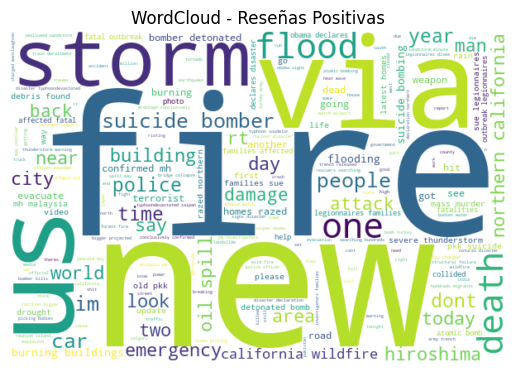

In [74]:
plt.imshow(wordcloud_dis, interpolation="bilinear")
plt.axis("off")
plt.title("WordCloud - Reseñas Positivas")
plt.show()

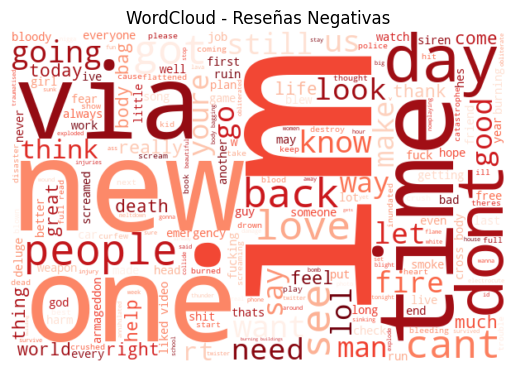

In [60]:
plt.imshow(wordcloud_non, interpolation="bilinear")
plt.axis("off")
plt.title("WordCloud - Reseñas Negativas")
plt.show()

In [66]:
vectorizer = CountVectorizer(ngram_range=(2,3))  # unigramas y bigramas
X = vectorizer.fit_transform(train["clean_text"])
y = train["target"]

print("Tamaño del vocabulario:", len(vectorizer.get_feature_names_out()))
print("Algunas palabras/bigramas:", list(vectorizer.get_feature_names_out())[:15])

Tamaño del vocabulario: 84573
Algunas palabras/bigramas: ['aa ayyo', 'aa ayyo dei', 'aa batteries', 'aa batteries swear', 'aaaa ok', 'aaaa ok lemme', 'aaaaaaallll im', 'aaaaaaallll im even', 'aaaaaand theres', 'aaaaaand theres thunder', 'aan den', 'aan den rijn', 'aannnnd reddit', 'aannnnd reddit quarantine', 'aar ambulancewe']


In [67]:
pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())

,aa ayyo,aa ayyo dei,aa batteries,aa batteries swear,aaaa ok,aaaa ok lemme,aaaaaaallll im,aaaaaaallll im even,aaaaaand theres,aaaaaand theres thunder,...,zouma absolutely,zouma absolutely flattened,zouma flattened,zouma flattened cfc,zouma flattened guy,zss vs,zss vs sws,zumiez location,zurich swiss,zurich swiss premiere
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7608,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7609,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7610,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7611,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Top 20 bigramas:
                  ngram  freq  n
0        suicide bomber    59  2
1     burning buildings    58  2
2   northern california    41  2
3           liked video    41  2
4            cross body    39  2
5             oil spill    39  2
6       suicide bombing    34  2
7   california wildfire    34  2
8            looks like    33  2
9           mass murder    32  2
10            full read    31  2
11     natural disaster    30  2
12        prebreak best    30  2
13     bomber detonated    30  2
14          homes razed    29  2
15         confirmed mh    29  2
16            heat wave    29  2
17       razed northern    28  2
18         latest homes    28  2
19          pkk suicide    28  2

Top 20 trigramas:
                                  ngram  freq  n
0              suicide bomber detonated    30  3
1          northern california wildfire    29  3
2                    latest homes razed    28  3
3                    pkk suicide bomber    28  3
4                  homes r

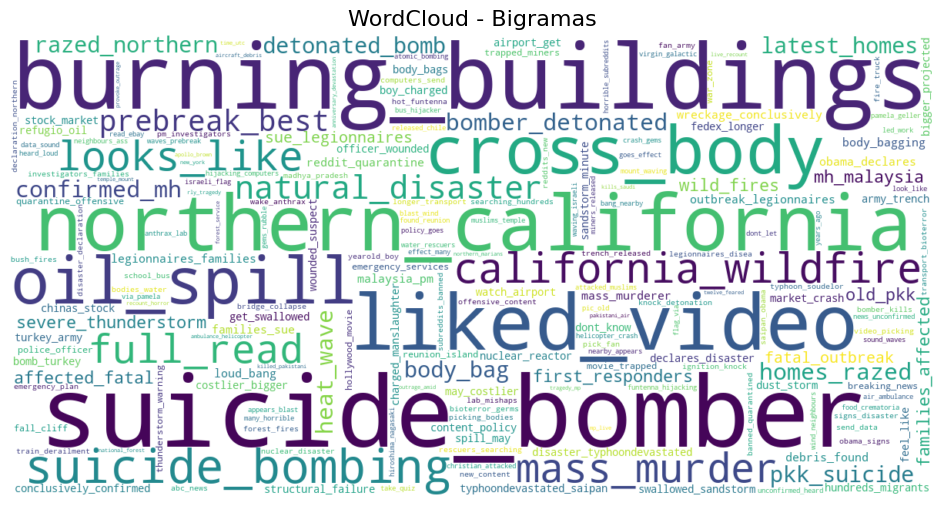

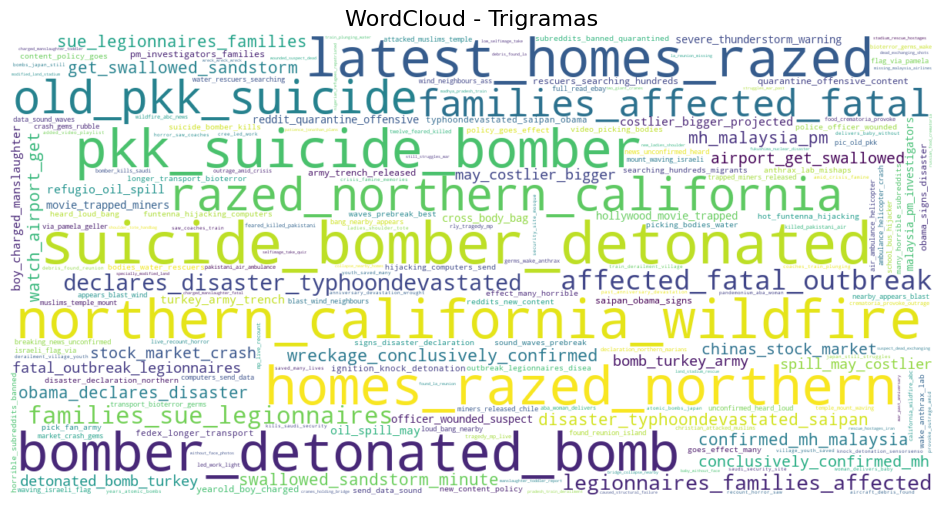

In [75]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# 1) Vectorizar (bi y tri-gramas)
vectorizer = CountVectorizer(ngram_range=(2,3))  # bigramas y trigramas
X = vectorizer.fit_transform(train["clean_text"].astype(str))
features = vectorizer.get_feature_names_out()

# 2) Frecuencia total por n-grama
freq = np.asarray(X.sum(axis=0)).ravel()
freq_df = pd.DataFrame({"ngram": features, "freq": freq})

# 3) Tablas separadas para bigramas y trigramas
#    (contamos espacios para inferir longitud: 'palabras' = espacios + 1)
freq_df["n"] = freq_df["ngram"].str.count(" ") + 1
bigrams_df  = freq_df[freq_df["n"] == 2].sort_values("freq", ascending=False).reset_index(drop=True)
trigrams_df = freq_df[freq_df["n"] == 3].sort_values("freq", ascending=False).reset_index(drop=True)

print("Top 20 bigramas:")
print(bigrams_df.head(20))
print("\nTop 20 trigramas:")
print(trigrams_df.head(20))

# 4) WordClouds por frecuencia
#    Para que cada n-grama se trate como una "palabra" en el wordcloud,
#    reemplazamos espacios por guiones bajos.
bigrams_freq_dict  = dict(zip(bigrams_df["ngram"].str.replace(" ", "_"), bigrams_df["freq"]))
trigrams_freq_dict = dict(zip(trigrams_df["ngram"].str.replace(" ", "_"), trigrams_df["freq"]))

def plot_wordcloud(freq_dict, title, max_words=200):
    wc = WordCloud(width=1200,
                   height=600,
                   background_color="white",
                   collocations=False,   # evita que el WC intente recombinar tokens
                   max_words=max_words)
    wc.generate_from_frequencies(freq_dict)
    plt.figure(figsize=(12,6))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(title, fontsize=16)
    plt.show()

# 5) Dibujar
plot_wordcloud(bigrams_freq_dict,  "WordCloud - Bigramas")
plot_wordcloud(trigrams_freq_dict, "WordCloud - Trigramas")